###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 二维SH有限差分建模 - 四分之一平面问题

在模拟Love波传播之前，让我们看看如何精确地利用四分之一平面问题来模拟来自自由表面边界的反射体波。这是一个重要的方面，因为理解Love波的一种方法是通过分层介质中SH体波的干涉。

## 二维SH四分之一平面问题的解析解

我们寻求二维各向同性弹性SH问题的解析解: 

\begin{align}
\rho \frac{\partial v_y}{\partial t} &= \frac{\partial \sigma_{yx}}{\partial x} + \frac{\partial \sigma_{yz}}{\partial z} + f_y, \notag\\
\frac{\partial \sigma_{yx}}{\partial t} &= \mu \frac{\partial v_{y}}{\partial x},\notag\\
\frac{\partial \sigma_{yz}}{\partial t} &= \mu \frac{\partial v_{y}}{\partial z}. \notag\\
\end{align}

对于波在均匀介质中的传播, 我们设置 $\rho$ 和剪切模量 $\mu$ 为常数 $\rho_0,\; \mu_0$

\begin{align}
\rho(i,j) &= \rho_0 \notag \\
\mu(i,j) &= \mu_0 = \rho_0 V_{s0}^2\notag
\end{align}

在每个空间网格点 $i = 0, 1, 2, ..., nx$; $j = 0, 1, 2, ..., nz$, 为了比较数值解和解析解。 为了完整地描述这个问题，我们还必须定义初始条件和边界条件。 **初始条件** 为 

\begin{equation}
v_y(i,j,0) = \sigma_{yx}(i+1/2,j,0) = \sigma_{yz}(i,j+1/2,0) = 0, \nonumber
\end{equation}

因此，在每个空间网格点上，建模从零粒子速度和剪应力振幅开始。关于 **边界条件**, 我们假设 

\begin{align}
v_y(0,j,n) &= \sigma_{yx}(1/2,j,n) = \sigma_{yz}(0,j+1/2,n) = 0, \nonumber\\
v_y(nx,j,n) &= \sigma_{yx}(nx+1/2,j,n) = \sigma_{yz}(nx,j+1/2,n) = 0, \nonumber\\
v_y(i,0,n) &= \sigma_{yx}(i+1/2,0,n) = \sigma_{yz}(i,1/2,n) = 0, \nonumber\\
v_y(i,nz,n) &= \sigma_{yx}(i+1/2,nz,n) = \sigma_{yz}(i,nz+1/2,n) = 0, \nonumber\\
\end{align}

对所有时间步长 n. 这个 **Dirichlet边界条件**, 会导致人工的边界反射。在 [上一节](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/06_2D_SH_Love_wave_modelling/2_From_2D_acoustic_to_SH_FD_modelling_final.ipynb), 我们忽略掉这些反射。在这种情况下，我们希望将它们合并到解析解中，以测试边界反射实际有多精确。我们可以描述反射通过使用 **image points**

<img src="images/SH_quarter_problem.jpg" width="60%">

这里，我们激发了均质介质的格林函数解:

\begin{equation}
G_{2D}(x,z,t,xsrc,zsrc) = \dfrac{1}{2\pi \rho_0 V_{s0}^2}\dfrac{H\biggl((t-t_s)-\dfrac{|r|}{V_{s0}}\biggr)}{\sqrt{(t-t_s)^2-\dfrac{r^2}{V_{s0}^2}}}, \nonumber 
\end{equation}

 $H$ 表示Heaviside function, $r = \sqrt{(x-x_s)^2+(z-z_s)^2}$ 表示震源-接收器之间的距离，在成像点 ... 

- 1 (-xsrc, zsrc) 用来描述左侧自由边界的反射
- 2 (-xsrc, -zsrc) 用来描述左底角自由边界的反射
- 3 (xsrc, -zsrc) 用来描述底部自由边界的反射

使用线性偏微分方程的 **叠加原理** , 我们可以用以下方法描述源和反射波场的格林函数解

\begin{align}
G_{2D}^{total}(x,z,t,xsrc,zsrc) &= G_{2D}^{source}(x,z,t,xsrc,zsrc) + G_{2D}^{image1}(x,z,t,-xsrc,zsrc)\nonumber\\  
&+ G_{2D}^{image2}(x,z,t,-xsrc,-zsrc) + G_{2D}^{image3}(x,z,t,xsrc,-zsrc)\nonumber\\
\end{align}

对于给定的震源子波 S，我们得到位移波场:

\begin{equation}
u_{y,analy}^{total}(x,z,t) = G_{2D}^{total} * S \nonumber 
\end{equation}

记住，应力-速度代码计算的是 **粒子速度** $\mathbf{v_{y,analy}^{total}}$, 而解析解则用 **位移** 表示$\mathbf{u_{y,analy}^{total}}$. 因此，在比较数值解和解析解之前，我们必须对解析解求一阶导数:


\begin{equation}
v_{y,analy}^{total}(x,z,t) = \frac{\partial u_{y,analy}^{total}}{\partial t} \nonumber 
\end{equation}

In [1]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)

tmax = 1.12   # maximum recording time of the seismogram (s)

vs0  = 580.   # S-wave speed in medium (m/s)
rho0 = 1000.  # Density in medium (kg/m^3)

# acquisition geometry
xr = 125.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = xsrc  # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

要构建有限差分代码，我们首先定义速度更新 $v_y$ ...

In [3]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho, op):
    
    # 2nd order FD operator
    if (op==2):   
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
            
                # Calculate spatial derivatives  (2nd order operator)           
                syx_x = (syx[i,j] - syx[i - 1,j]) / dx
                syz_z = (syz[i,j] - syz[i,j - 1]) / dz
            
                # Update particle velocities
                vy[i,j] = vy[i,j] + (dt/rho[i,j]) * (syx_x + syz_z)                               
                
    return vy

... 更新剪应力分量 $\sigma_{yx}$ 和 $\sigma_{yz}$ ...

In [4]:
# Shear stress syx, syz updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz, op):
    
    # 2nd order FD operator
    if(op==2):
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
            
                # Calculate spatial derivatives (2nd order operator)
                vy_x = (vy[i + 1,j] - vy[i,j]) / dx
                vy_z = (vy[i,j + 1] - vy[i,j]) / dz
            
                # Update shear stresses
                syx[i,j] = syx[i,j] + dt * mux[i,j] * vy_x
                syz[i,j] = syz[i,j] + dt * muz[i,j] * vy_z                    
    
    return syx, syz

... 和剪切模量谐波平均 ...

In [5]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate harmonic averages of shear moduli        
            mux[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])
            muz[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
            
    return mux, muz

最后，我们定义了一个函数来计算任意源位置或像点处的格林函数 ...

In [6]:
def Green_2D(ir, jr, xsrc, zsrc, x, z, vs0, rho0, time, G, nt):
    
    # calculate source-receiver distance
    #r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)
    r = np.sqrt((x[ir] - xsrc)**2 + (z[jr] - zsrc)**2)
    
    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vs0) >= 0:
            G[it] = 1. / (2 * np.pi * rho0 * vs0**2) * (1. / np.sqrt(time[it]**2 - (r/vs0)**2))
    
    return G

... 组合以上代码 ...

In [7]:
# 2D SH Wave Propagation (Finite Difference Solution) 
# ---------------------------------------------------
def FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
    
    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction
    
    # half FD-operator length
    noph = (int)(op/2)

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G        = time * 0.
    G1       = time * 0.
    G2       = time * 0.
    G3       = time * 0.
    vy_analy = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate 2D Green's function for direct SH wave from source position    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction
    
    # calculate source position from isrc and jsrc
    xsrcd = isrc * dx
    zsrcd = jsrc * dz
    
    G = Green_2D(ir, jr, xsrcd, zsrcd, x, z, vs0, rho0, time, G, nt)
    
    # calculate 2D Green's function for image points
    # shift image points by half the FD operator size to compare with FD solution
    G1 = Green_2D(ir, jr, -xsrcd + noph*dx, zsrcd, x, z, vs0, rho0, time, G1, nt)
    G2 = Green_2D(ir, jr, xsrcd, -zsrcd+noph*dz, x, z, vs0, rho0, time, G2, nt)
    G3 = Green_2D(ir, jr, -xsrcd+noph*dx, -zsrcd+noph*dz, x, z, vs0, rho0, time, G3, nt)
    
    G = G + G1 + G2 + G3 
    
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    
    # compute vy_analy from uy_analy
    for i in range(1, nt - 1):
        vy_analy[i] = (Gc[i+1] - Gc[i-1]) / (2.0 * dt)           
    
    # Initialize empty pressure arrays
    # --------------------------------
    vy    = np.zeros((nx,nz)) # particle velocity vy
    syx   = np.zeros((nx,nz)) # shear stress syx
    syz   = np.zeros((nx,nz)) # shear stress syz        

    # Initialize model (assume homogeneous model)
    # -------------------------------------------    
    vs    = np.zeros((nx,nz))
    vs    = vs + vs0      # initialize wave velocity in model
    
    rho   = np.zeros((nx,nz))
    rho   = rho + rho0    # initialize wave velocity in model
    
    # calculate shear modulus
    mu    = np.zeros((nx,nz))
    mu    = rho * vs ** 2 
    
    # harmonic average of shear moduli
    # --------------------------------
    mux   = mu # initialize harmonic average mux 
    muz   = mu # initialize harmonic average muz

    mux, muz = shear_avg(mu, nx, nz, mux, muz)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt)     
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho, op)

        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc,jsrc] = vy[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dx * dz))
        
        # Update shear stress syx, syz
        # ----------------------------
        syx, syz = update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz, op)                
                           
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir,jr]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,vy_analy,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()     
    
    return vy

首先，我们用空间二阶算子将解析解与有限差分建模结果进行比较和一个波场采样 $N_\lambda = 12$ 每最小波长的网格点:

nx =  827
nz =  827
nt =  1520


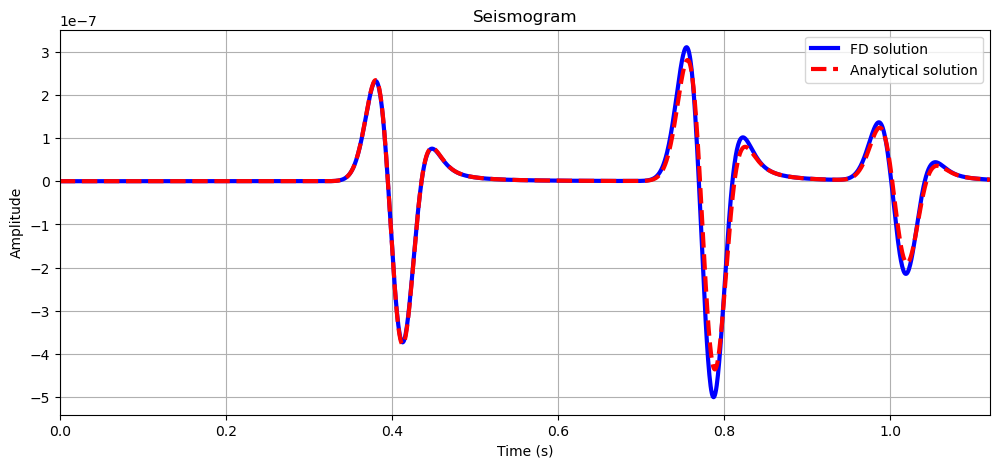

In [8]:
Nlam = 12
dx = vs0 / (Nlam * 2 * f0)
dz   = dx    # grid point distance in z-direction (m)

op = 2       # order of spatial FD operator

# calculate dt according to CFL criterion
dt = dx / (np.sqrt(2) * vs0) 

vy = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op)

同时，对SH波的模拟非常精确，可以提高边界反射波形的拟合性。让我们在每个最小波长上尝试更多的网格点 ($N_\lambda = 16$)...

nx =  1103
nz =  1103
nt =  2027


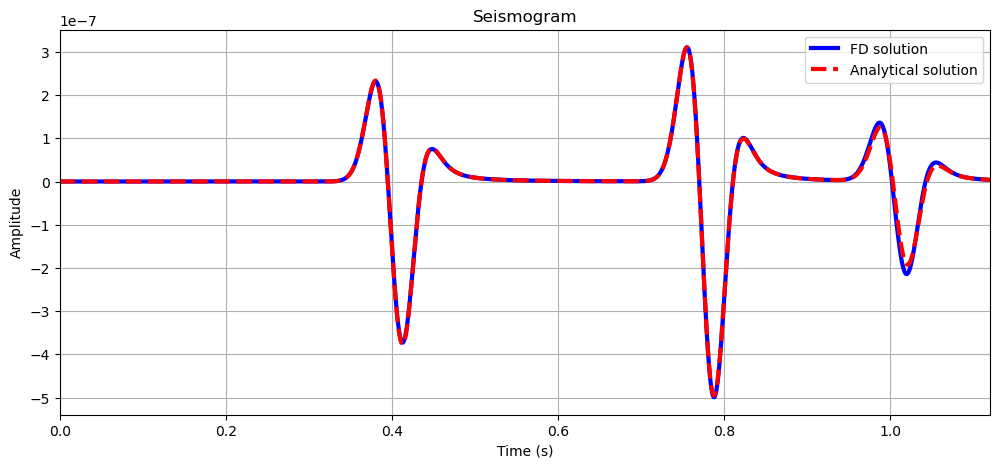

In [9]:
Nlam = 16
dx = vs0 / (Nlam * 2 * f0)
dz   = dx    # grid point distance in z-direction (m)

op = 2       # order of spatial FD operator

# calculate dt according to CFL criterion
dt = dx / (np.sqrt(2) * vs0) 

vy = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op)

... 这样可以改进边界反射的波形拟合。

## 我们学习到:

* 利用线性偏微分方程的象法和叠加原理估计四分之一平面问题的解析解
* 为了精确地模拟边界反射，我们至少要使用 $N_\lambda = 16$ 每波长网格点对于二阶有限差分算子